# Aprendizado Supervisionado

Jaime Hikaru Mishima

## Small Business Administration (SBA) Historical Loans (7a and 504)
Over 1.6M loans guaranteed by the SBA to small businesses as part of their 7(a) and 504 Loan programs. Dataset includes including the name, address, and industry of the recipient as well as the loan amount, term current status and issuing bank details.

7(a) Loans: SBA 7(a) loans are for a maximum of 2 million dollars, with SBA loan guarantee of no more than 1.5 million dollars (75%).

504 Loans: The 504 Loan Program provides approved small businesses with long-term, fixed-rate financing used to acquire fixed assets for expansion or modernization. 504 loans are made available through Certified Development Companies (CDCs), SBA's community based partners for providing 504 Loans.

[Base Location](https://aws.amazon.com/marketplace/pp/prodview-27syih2hg4av2?qid=1587175655831&sr=0-25&ref_=srh_res_product_title#overview)
<br>
[Source](https://www.sba.gov/about-sba/open-government/foia#section-header-32)


## Previsão de Default em Empréstimos
**Contexto**: A Small Business Administration (SBA) é uma agência norte-americana que apoia as pequenas empresas. A SBA conecta empreendedores com credores e financiamento para ajudá-los a planejar, iniciar e expandir seus negócios. Com uma base histórica de empréstimos feitos desde 2009, a ideia é prever o não pagamento de acordo com variáveis de negócio.

## 0. Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
import fklearn, matplotlib
from tqdm import tqdm

# Built-in python libraries
import sys
import os
from urllib.request import urlretrieve

from sklearn.feature_selection import SelectKBest, chi2 
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from fklearn.preprocessing.splitting import time_split_dataset
from fklearn.preprocessing.splitting import space_time_split_dataset

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools
from itertools import groupby
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [2]:
print("Python version:\n{}\n".format(sys.version))
print("matplotlib version: {}".format(matplotlib.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))

Python version:
3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]

matplotlib version: 3.1.1
pandas version: 0.24.2
numpy version: 1.16.6


In [3]:
#from HelperMethods import HelperClass
# https://github.com/jaimemishima/Data-Science-Projects/blob/master/Credit%20Card%20Fraud%20Detection.ipynb
class HelperClass(object):
        
    # helper method
    @staticmethod
    def stars():
        print ("***********************")
    
    # print metrics as dataframe
    @staticmethod
    def print_dataframe(values):
    
        metrics_print = ['True Positive', 'True Negative', 'False Negative', 'False Positive',
    'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'Roc Auc Score']

        df_metrics = pd.DataFrame(
            {'Metrics': metrics_print,
             'Values': values
            })

        print (df_metrics.to_string(header=False, index=False))
        HelperClass.stars()
        
                
        
    # Disclaimer: metodo obtido em:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    # Metodo para plotar a matrix de confusao
    @staticmethod
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix:")
        else:
            print('Confusion matrix, without normalization:')

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        # adjust plot
        
        bottom, top = plt.gca().get_ylim()
        plt.gca().set_ylim(bottom + 0.5, top - 0.5)
        plt.show()




    # ROC curve
    @staticmethod
    def plot_roc_curve(y_true, y_scores):

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        HelperClass.stars()
        print ("Roc Curve:")
        HelperClass.stars()

        plt.plot(fpr, tpr, label = 'ROC Curve', linewidth = 2)
        plt.plot([0,1],[0,1], 'k--', linewidth = 2)
        plt.title('ROC Curve')
        plt.xlim([0.0, 0.001])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()



    # Precision Recall Curve
    @staticmethod
    def plot_precision_recall_curve(y_true, y_scores):

        HelperClass.stars()
        print ("Precision Recall Curve:")
        HelperClass.stars()

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

        plt.step(recall, precision, color = 'b', alpha = 0.2, where = 'post')

        plt.plot(recall, precision, linewidth=2)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.show()



    # Show classification report
    @staticmethod
    def show_full_classification_report(y_true, y_pred, y_scores, classes):

        HelperClass.stars()
        print ("Metrics Report:")
        HelperClass.stars()

        cm = confusion_matrix(y_true, y_pred)

        true_positive = cm[1,1]
        true_negative = cm[0,0]
        false_negative = cm[1,0]
        false_positive = cm[0,1]

        accuracy = ((true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive))
        precision = (true_positive/(true_positive + false_positive))
        recall = (true_positive/(true_positive + false_negative))  
        sensitivity = (true_positive/(true_positive + false_negative))  
        specificity = (true_negative/(true_negative + false_positive))  
        f1_score = ((2 * precision * recall)/(precision + recall))
        
        roc_auc = roc_auc_score(y_true, y_scores)

        print ("Classification Report:")
        HelperClass.stars()

        values = []

        values.append(true_positive)
        values.append(true_negative)
        values.append(false_negative)
        values.append(false_positive)
        values.append('{:.4f}'.format(accuracy))
        values.append('{:.4f}'.format(precision))
        values.append('{:.4f}'.format(recall))
        values.append('{:.4f}'.format(specificity))
        values.append('{:.4f}'.format(f1_score))
        values.append('{:.4f}'.format(roc_auc))

        HelperClass.print_dataframe(values)

        HelperClass.plot_confusion_matrix(cm, classes)

        HelperClass.plot_roc_curve(y_true, y_scores)

        HelperClass.plot_precision_recall_curve(y_true, y_scores)


    def plot_corr_matrix(correlations,attr, figsize=[15,10]):
      """Retorna o heatmap de uma lista de listas com as correlacoes de variaveis
      Args:
        correlations - lista de lista com as correlacoes
        attr - lista com os nomes das variaveis
        fig_no - If not provided, a new figure will be created, and the figure number will be incremented (para o plt.figure)
        figsize 0- tamanho do heatmap
      Returns:
        Heatmap com a matriz de correlacao
        """
      fig=plt.figure(figsize=figsize)
      ax=fig.add_subplot(111)
      ax.set_title("Correlacao Variaveis")
      ax = sns.heatmap(correlations, cmap="YlGnBu")
      indice = list(range(1, len(attr)+1))
      indice = [str(s) + ' - ' for s in indice]
      res = [i + j for i, j in zip(indice, attr)] 
      #ax.set_xticks(range(len(filter_colunas_order)))
      ax.set_yticklabels(res)
      plt.yticks(rotation=0) 
      plt.show()

In [4]:
pd.set_option('display.max_columns', None) # para mostrar todas as colunas

## 1. Tratamento da Base

In [4]:
# raw = pd.read_excel("FOIA - 7(a)(FY2010-Present).xlsx", sheet_name="7A_FY2010_Present")
# raw.to_csv("foia_7a.csv",index = False, header=True)

In [66]:
raw_base = pd.read_csv("foia_7a.csv")

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (11,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
df = raw_base.copy()
df.head(100)

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,BankName,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,PaidInFullDate,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported
0,20191231,7A,"CRESA PARTNERS - DENVER, INC.",7979 E TUFTS AVE PKWY STE 810,DENVER,CO,80237,"Zions Bank, A Division of",1 S Main St,SALT LAKE CITY,UT,84133,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.00,Offices of Real Estate Agents and Brokers,NaN,NaN,DENVER,CO,COLORADO DISTRICT OFFICE,1.00,CORPORATION,PIF,2016-10-31,NaN,0,1,35
1,20191231,7A,The Hilltop Tavern,4757 Folsom Blvd,Sacramento,CA,95819,Plumas Bank,336 W Main St,QUINCY,CA,95971,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.00,Drinking Places (Alcoholic Beverages),NaN,NaN,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.00,CORPORATION,PIF,2019-03-31,NaN,0,0,6
2,20191231,7A,River City Car Wash LLC,649 Harbor Blvd,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",101 N Philips Ave,SIOUX FALLS,SD,57104,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.00,Car Washes,NaN,NaN,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.00,CORPORATION,CHGOFF,NaN,2015-08-24,320098,0,27
3,20191231,7A,Alphagraphics,71 Newtown Road.,Danbury,CT,6810,Union Savings Bank,226 Main St,DANBURY,CT,6810,100000,50000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.25,84,323110.00,Commercial Lithographic Printing,03512,"ALPHAGRAPHICS, PRINTSHOPS OF T",FAIRFIELD,CT,CONNECTICUT DISTRICT OFFICE,4.00,CORPORATION,EXEMPT,NaN,NaN,0,1,5
4,20191231,7A,ON SITE AUTOMOTIVE APPEARANCE,603 WOODBRIDGE COURT,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",9385 Haven Avenue,Rancho Cucamonga,CA,91730,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.00,"Automotive Body, Paint, and Interior Repair an...",NaN,NaN,ELKHART,IN,INDIANA DISTRICT OFFICE,2.00,INDIVIDUAL,PIF,2013-02-28,NaN,0,0,2
5,20191231,7A,AW ENTERPRISES,106 WEST LAKE STREET,CAMDEN,TN,38320,"VelocitySBA, LLC",9385 Haven Avenue,Rancho Cucamonga,CA,91730,10000,9000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.24,120,453220.00,"Gift, Novelty, and Souvenir Stores",NaN,NaN,BENTON,TN,TENNESSEE DISTRICT OFFICE,7.00,INDIVIDUAL,PIF,2019-10-31,NaN,0,0,3
6,20191231,7A,TA SPECIALTY,331 HEATHERSTONE ROAD,COLUMBIA,SC,29212,"VelocitySBA, LLC",9385 Haven Avenue,Rancho Cucamonga,CA,91730,20000,18000,2009-10-01,2010,2009-10-01,PATRIOT EX,Patriot Express,7.75,120,541890.00,Other Services Related to Advertising,NaN,NaN,LEXINGTON,SC,SOUTH CAROLINA DISTRICT OFFICE,2.00,INDIVIDUAL,PIF,2017-03-31,NaN,0,0,4
7,20191231,7A,"Hansen Concrete, Inc.",8656 71st Street NE,SPICER,MN,56288,Lake Region Bank,51 Main St,NEW LONDON,MN,56273,200000,100000,2009-10-01,2010,2009-12-01,SBA EXPRES,FA$TRK (Small Loan Express),7.50,60,236220.00,Commercial and Institutional Building Construc...,NaN,NaN,KANDIYOHI,MN,MINNESOTA DISTRICT OFFICE,7.00,CORPORATION,PIF,2012-02-29,NaN,0,1,12
8,20191231,7A,SHADIA'S SECRETS INC,950 GLADES RD 2ND FLOOR,BOCA RATON,FL,33431,"VelocitySBA, LLC",9385 Haven Avenue,Rancho Cucamonga,CA,91730,15000,13500,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,446199.00,All Other Health and Personal Care Stores,NaN,NaN,PALM BEACH,FL,SOUTH FLORIDA DISTRICT OFFICE,22.00,CORPORATION,PIF,2019-10-31,NaN,0,0,1
9,20191231,7A,JT'S COFFEE AND SANDWICH SHOP,1167 HARRISON STREET,SAN FRANCISCO,CA,94103,"VelocitySBA, LLC",9385 Haven Avenue,Rancho Cucamonga,CA,91730,20000,18000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,722213.00,Snack and Nonalcoholic Beverage Bars,NaN,NaN,SAN FRANCISCO,CA,SAN FRANCISCO DISTRICT OFFICE,12.00,CORPORATI

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557542 entries, 0 to 557541
Data columns (total 36 columns):
AsOfDate                 557542 non-null int64
Program                  557542 non-null object
BorrName                 557504 non-null object
BorrStreet               557542 non-null object
BorrCity                 557542 non-null object
BorrState                557542 non-null object
BorrZip                  557542 non-null int64
BankName                 557542 non-null object
BankStreet               557539 non-null object
BankCity                 557539 non-null object
BankState                557539 non-null object
BankZip                  557539 non-null object
GrossApproval            557542 non-null int64
SBAGuaranteedApproval    557542 non-null int64
ApprovalDate             557542 non-null object
ApprovalFiscalYear       557542 non-null int64
FirstDisbursementDate    479351 non-null object
DeliveryMethod           557542 non-null object
subpgmdesc               55754

In [41]:
# Date treatment
df['AsOfDate'] = df['AsOfDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['ApprovalDate'] = df['ApprovalDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['PaidInFullDate'] = df['PaidInFullDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['Target'] = np.where(df['PaidInFullDate'].isnull(), 1, 0)

In [71]:
df['BankZip']

0         84133
1         95971
2         57104
3          6810
4         91730
5         91730
6         91730
7         56273
8         91730
9         91730
10        91730
11        91730
12        57104
13        90010
14        57104
15        91506
16        54017
17        38804
18          918
19        72501
20        77418
21         1960
22        10009
23        92128
24        90010
25        81428
26        90010
27        54301
28        81428
29        45202
          ...  
557512    75201
557513    45263
557514    57104
557515    49014
557516    62703
557517    12801
557518    30326
557519    75219
557520    57104
557521    28403
557522    84405
557523    19801
557524     2492
557525    92614
557526    67202
557527    28403
557528    37643
557529    60603
557530     6901
557531      908
557532    17602
557533    57104
557534    43215
557535    57104
557536    19808
557537    46601
557538    19808
557539    70501
557540    47129
557541    47129
Name: BankZip, Length: 5

In [42]:
df['LoanStatus'].value_counts()

EXEMPT    262118
PIF       198609
CANCLD     62404
CHGOFF     18380
COMMIT     16031
Name: LoanStatus, dtype: int64

In [43]:
# vamos manter somente os emprestimos que foram totalmente pagos (PIF = Paid in Full) e cobrados (CHGOFF = Charged Off)
# COMMIT = não desembolsado, CANCLD = cancelado, EXEMPT = foram desembolsados mas não foram cancelados, cobrados ou pagos.
df = df[df['LoanStatus'].isin(['PIF', 'CHGOFF'])]

In [44]:
df.to_csv("foia_7a_tratado.csv",index = False, header=True)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/botocore/awsrequest.py:624: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HeadersDict(collections.MutableMapping):


In [54]:
df = pd.read_csv("foia_7a_tratado.csv")

In [55]:
df.columns

Index(['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BorrCity',
       'BorrState', 'BorrZip', 'BankName', 'BankStreet', 'BankCity',
       'BankState', 'BankZip', 'GrossApproval', 'SBAGuaranteedApproval',
       'ApprovalDate', 'ApprovalFiscalYear', 'FirstDisbursementDate',
       'DeliveryMethod', 'subpgmdesc', 'InitialInterestRate', 'TermInMonths',
       'NaicsCode', 'NaicsDescription', 'FranchiseCode', 'FranchiseName',
       'ProjectCounty', 'ProjectState', 'SBADistrictOffice',
       'CongressionalDistrict', 'BusinessType', 'LoanStatus', 'PaidInFullDate',
       'ChargeOffDate', 'GrossChargeOffAmount', 'RevolverStatus',
       'JobsSupported', 'Target'],
      dtype='object')

In [56]:
#df['AsOfDate'] = df['AsOfDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['ApprovalDate'] = df['ApprovalDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
#df['PaidInFullDate'] = df['PaidInFullDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [57]:
print("Base começa  em: "+ str(df['ApprovalDate'].min()))
print("Base termina em: "+ str(df['ApprovalDate'].max()))

Base começa  em: 2009-10-01 00:00:00
Base termina em: 2019-09-30 00:00:00


In [64]:
# removing unnused columns
df = df.drop(columns=['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BankStreet', 'LoanStatus'])

# removing variables related with target
df = df.drop(columns=['PaidInFullDate', 'ChargeOffDate', 'GrossChargeOffAmount'])

# converting categorical columns
df['NaicsCode'] = df['NaicsCode'].astype(str)
df['CongressionalDistrict'] = df['CongressionalDistrict'].astype(str)
df['BorrZip'] = df['BorrZip'].astype(str)
df['BankZip'] = df['BankZip'].astype(str)
df['FranchiseCode'] = df['FranchiseCode'].astype(str)
df['FranchiseName'] = df['FranchiseName'].astype(str)

df['Id'] = range(1, 1+len(df))
dados = df.copy()

ValueError: invalid literal for int() with base 10: '531210.0'

In [52]:
dados.head(100)

,BorrCity,BorrState,BorrZip,BankName,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,RevolverStatus,JobsSupported,Target,Id
0,DENVER,CO,80237,"Zions Bank, A Division of",SALT LAKE CITY,UT,84133.0,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.0,Offices of Real Estate Agents and Brokers,NaN,NaN,DENVER,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,1,35,0,1
1,Sacramento,CA,95819,Plumas Bank,QUINCY,CA,95971.0,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.0,Drinking Places (Alcoholic Beverages),NaN,NaN,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.0,CORPORATION,0,6,0,2
2,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",SIOUX FALLS,SD,57104.0,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.0,Car Washes,NaN,NaN,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.0,CORPORATION,0,27,1,3
3,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.0,"Automotive Body, Paint, and Interior Repair an...",NaN,NaN,ELKHART,IN,INDIANA DISTRICT OFFICE,2.0,INDIVIDUAL,0,2,0,4
4,CAMDEN,TN,38320,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,10000,9000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.24,120,453220.0,"Gift, Novelty, and Souvenir Stores",NaN,NaN,BENTON,TN,TENNESSEE DISTRICT OFFICE,7.0,INDIVIDUAL,0,3,0,5
5,COLUMBIA,SC,29212,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,20000,18000,2009-10-01,2010,2009-10-01,PATRIOT EX,Patriot Express,7.75,120,541890.0,Other Services Related to Advertising,NaN,NaN,LEXINGTON,SC,SOUTH CAROLINA DISTRICT OFFICE,2.0,INDIVIDUAL,0,4,0,6
6,SPICER,MN,56288,Lake Region Bank,NEW LONDON,MN,56273.0,200000,100000,2009-10-01,2010,2009-12-01,SBA EXPRES,FA$TRK (Small Loan Express),7.50,60,236220.0,Commercial and Institutional Building Construc...,NaN,NaN,KANDIYOHI,MN,MINNESOTA DISTRICT OFFICE,7.0,CORPORATION,1,12,0,7
7,BOCA RATON,FL,33431,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,15000,13500,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,446199.0,All Other Health and Personal Care Stores,NaN,NaN,PALM BEACH,FL,SOUTH FLORIDA DISTRICT OFFICE,22.0,CORPORATION,0,1,0,8
8,SAN FRANCISCO,CA,94103,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,20000,18000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,722213.0,Snack and Nonalcoholic Beverage Bars,NaN,NaN,SAN FRANCISCO,CA,SAN FRANCISCO DISTRICT OFFICE,12.0,CORPORATION,0,4,0,9
9,Phoenix,IL,60426,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,44,441120.0,Used Car Dealers,NaN,NaN,COOK,IL,ILLINOIS DISTRICT OFFICE,1.0,CORPORATION,0,3,1,10


In [59]:
dados.to_parquet('dados_200705.parquet.gzip', compression='gzip')

In [72]:
dados = pd.read_parquet('dados_200705.parquet.gzip')

In [73]:
dados.columns

Index(['BorrCity', 'BorrState', 'BorrZip', 'BankName', 'BankCity', 'BankState',
       'BankZip', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate',
       'ApprovalFiscalYear', 'FirstDisbursementDate', 'DeliveryMethod',
       'subpgmdesc', 'InitialInterestRate', 'TermInMonths', 'NaicsCode',
       'NaicsDescription', 'FranchiseCode', 'FranchiseName', 'ProjectCounty',
       'ProjectState', 'SBADistrictOffice', 'CongressionalDistrict',
       'BusinessType', 'RevolverStatus', 'JobsSupported', 'Target', 'Id'],
      dtype='object')

## 2. Análise Exploratória

Análise exploratória serve para desvendar um pouco do processo gerador de dados. Quanto mais souber sobre como os dados são gerados, melhor será as chances de usar a técnica de modelagem mais adequada. Algumas análises são padrões em todos os processos de análise exploratória:

1. Análise de distribuição. Ex: qual a média, mínimo e máximo de cada variável
2. Análise de dados faltantes. Ex: Quais variáveis têm dados faltantes? Qual a proporção de dados faltantes por variável? Porque esses dados estão faltando? É um bug ou uma característica do processo gerador de dados?
3. Variáveis categóricas. Existem variáveis categóricas? Qual a cardinalidade das variáveis categóricas? As categorias são ordenadas ou sem ordem?
4. Correlação. Qual a correlação entre variáveis?
5. Censura: Quais as limitações do target? Há algum processo de espera temporal entre a observação das variáveis e a observação do target (em problemas de previsão, a resposta geralmente é sim!). Como é esse processo. Há alguma outra variável que limite o target?

In [62]:
dados.head(50)

,BorrCity,BorrState,BorrZip,BankName,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,RevolverStatus,JobsSupported,Target,Id
0,DENVER,CO,80237,"Zions Bank, A Division of",SALT LAKE CITY,UT,84133.0,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.0,Offices of Real Estate Agents and Brokers,nan,nan,DENVER,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,1,35,0,1
1,Sacramento,CA,95819,Plumas Bank,QUINCY,CA,95971.0,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.0,Drinking Places (Alcoholic Beverages),nan,nan,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.0,CORPORATION,0,6,0,2
2,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",SIOUX FALLS,SD,57104.0,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.0,Car Washes,nan,nan,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.0,CORPORATION,0,27,1,3
3,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.0,"Automotive Body, Paint, and Interior Repair an...",nan,nan,ELKHART,IN,INDIANA DISTRICT OFFICE,2.0,INDIVIDUAL,0,2,0,4
4,CAMDEN,TN,38320,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,10000,9000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.24,120,453220.0,"Gift, Novelty, and Souvenir Stores",nan,nan,BENTON,TN,TENNESSEE DISTRICT OFFICE,7.0,INDIVIDUAL,0,3,0,5
5,COLUMBIA,SC,29212,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,20000,18000,2009-10-01,2010,2009-10-01,PATRIOT EX,Patriot Express,7.75,120,541890.0,Other Services Related to Advertising,nan,nan,LEXINGTON,SC,SOUTH CAROLINA DISTRICT OFFICE,2.0,INDIVIDUAL,0,4,0,6
6,SPICER,MN,56288,Lake Region Bank,NEW LONDON,MN,56273.0,200000,100000,2009-10-01,2010,2009-12-01,SBA EXPRES,FA$TRK (Small Loan Express),7.50,60,236220.0,Commercial and Institutional Building Construc...,nan,nan,KANDIYOHI,MN,MINNESOTA DISTRICT OFFICE,7.0,CORPORATION,1,12,0,7
7,BOCA RATON,FL,33431,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,15000,13500,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,446199.0,All Other Health and Personal Care Stores,nan,nan,PALM BEACH,FL,SOUTH FLORIDA DISTRICT OFFICE,22.0,CORPORATION,0,1,0,8
8,SAN FRANCISCO,CA,94103,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,20000,18000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,722213.0,Snack and Nonalcoholic Beverage Bars,nan,nan,SAN FRANCISCO,CA,SAN FRANCISCO DISTRICT OFFICE,12.0,CORPORATION,0,4,0,9
9,Phoenix,IL,60426,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,44,441120.0,Used Car Dealers,nan,nan,COOK,IL,ILLINOIS DISTRICT OFFICE,1.0,CORPORATION,0,3,1,10


### 2.1 Análise de distribuição

In [63]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dados.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GrossApproval,216989.00,313933.06,597664.30,1000.00,30000.00,100000.00,300000.00,5000000.00
SBAGuaranteedApproval,216989.00,233800.52,469588.56,500.00,17500.00,53000.00,204975.00,5250000.00
ApprovalFiscalYear,216989.00,2012.91,2.23,2010.00,2011.00,2013.00,2015.00,2019.00
InitialInterestRate,216989.00,6.32,1.43,0.00,5.50,6.00,7.05,12.50
TermInMonths,216989.00,104.08,73.26,0.00,60.00,84.00,120.00,360.00
RevolverStatus,216989.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
JobsSupported,216989.00,11.15,22.12,0.00,2.00,5.00,12.00,2150.00
Target,216989.00,0.08,0.28,0.00,0.00,0.00,0.00,1.00
Id,216989.00,108495.00,62639.47,1.00,54248.00,108495.00,162742.00,216989.00


In [32]:
dados.describe()

,GrossApproval,SBAGuaranteedApproval,ApprovalFiscalYear,InitialInterestRate,TermInMonths,RevolverStatus,JobsSupported,Id
count,211052.00,211052.00,211052.00,211052.00,211052.00,211052.00,211052.00,211052.00
mean,346061.85,261721.47,2011.71,6.24,117.33,0.30,11.79,105526.50
std,595050.73,471064.74,1.28,1.31,79.96,0.46,23.29,60925.61
min,1000.00,500.00,2010.00,0.66,0.00,0.00,0.00,1.00
25%,37500.00,21250.00,2011.00,5.50,72.00,0.00,2.00,52763.75
50%,120000.00,76500.00,2012.00,6.00,84.00,0.00,5.00,105526.50
75%,351000.00,270018.75,2013.00,7.00,120.00,1.00,12.00,158289.25
max,5000000.00,4500000.00,2014.00,11.52,720.00,1.00,2150.00,211052.00


### 2.2 Valores Nulos
Para a franquia, somente 7% da base tem o campo preenchido: `FranchiseCode` e `FranchiseName`

In [74]:
dados.isna().mean()

BorrCity                0.00
BorrState               0.00
BorrZip                 0.00
BankName                0.00
BankCity                0.00
BankState               0.00
BankZip                 0.00
GrossApproval           0.00
SBAGuaranteedApproval   0.00
ApprovalDate            0.00
ApprovalFiscalYear      0.00
FirstDisbursementDate   0.00
DeliveryMethod          0.00
subpgmdesc              0.00
InitialInterestRate     0.00
TermInMonths            0.00
NaicsCode               0.00
NaicsDescription        0.00
FranchiseCode           0.00
FranchiseName           0.00
ProjectCounty           0.00
ProjectState            0.00
SBADistrictOffice       0.00
CongressionalDistrict   0.00
BusinessType            0.00
RevolverStatus          0.00
JobsSupported           0.00
Target                  0.00
Id                      0.00
dtype: float64

### 2.3 Cardinalidade

In [18]:
dados.apply(pd.Series.nunique).sort_values()

RevolverStatus                2
Target                        2
BusinessType                  3
ApprovalFiscalYear           10
DeliveryMethod               15
subpgmdesc                   17
BankState                    54
CongressionalDistrict        55
ProjectState                 57
BorrState                    57
SBADistrictOffice            74
JobsSupported               284
TermInMonths                325
NaicsDescription           1175
NaicsCode                  1202
InitialInterestRate        1321
ProjectCounty              1789
BankCity                   1889
FranchiseName              2183
BankZip                    2504
FirstDisbursementDate      2696
BankName                   2751
FranchiseCode              2785
ApprovalDate               3051
GrossApproval             12192
SBAGuaranteedApproval     16879
BorrCity                  19226
BorrZip                   19571
Id                       216989
dtype: int64

### 2.5 Correlação
Queremos ver quais as variáveis que estão mais relacionadas com o target de alguma forma.

*TermsInMonths* parece ser uma variável bem forte, seguido de *InitialInterestRate*.

In [41]:
target = 'Target'
dados.corr(method='pearson')[target].sort_values()

TermInMonths            -0.166357
GrossApproval           -0.063513
SBAGuaranteedApproval   -0.058860
JobsSupported           -0.032113
Id                      -0.003241
ApprovalFiscalYear       0.000526
RevolverStatus           0.003237
InitialInterestRate      0.130976
Target                   1.000000
Name: Target, dtype: float64

É importante olhar como as features estão relacionadas entre si. 

Por exemplo, não queremos usar duas features muito correlacionadas no modelo ao mesmo tempo.

In [48]:
numeric_features = [column for column in dados.columns if dados[column].dtype in (int, float)]
numeric_features = list(set(numeric_features) - set(['Id']))

categorical_features = [column for column in dados.columns if dados[column].dtype not in (int, float)]

(8.0, -0.09999999999999998)

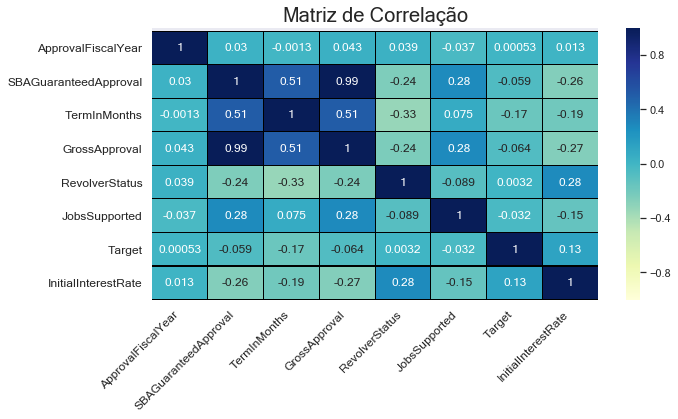

In [118]:
sns.set(font="Microsoft Sans Serif")
plt.figure(figsize=(10, 5))
ax = sns.heatmap(dados[numeric_features].corr(method='pearson'), annot = True, 
                 vmin=-1, vmax=1, center= 0, cmap= 'YlGnBu', 
                 linewidths=0.1, linecolor='black')
# rotate xlabel
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.axes.set_title("Matriz de Correlação",fontsize=20)
#ax.set_xlabel("X Label",fontsize=14)
#ax.set_ylabel("Y Label",fontsize=14)
ax.tick_params(labelsize=12)

# adjust plot
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.6)

## 3. Tratamento dos Dados
Imputação, dummies. Geracao da ABT de modelagem

In [18]:
dados.head()

,BorrCity,BorrState,BorrZip,BankName,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,RevolverStatus,JobsSupported,Id
0,DENVER,CO,80237,"Zions Bank, A Division of",SALT LAKE CITY,UT,84133,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.0,Offices of Real Estate Agents and Brokers,NaN,NaN,DENVER,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,1,35,1
1,Sacramento,CA,95819,Plumas Bank,QUINCY,CA,95971,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.0,Drinking Places (Alcoholic Beverages),NaN,NaN,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.0,CORPORATION,0,6,2
2,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",SIOUX FALLS,SD,57104,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.0,Car Washes,NaN,NaN,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.0,CORPORATION,0,27,3
3,Danbury,CT,6810,Union Savings Bank,DANBURY,CT,6810,100000,50000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.25,84,323110.0,Commercial Lithographic Printing,03512,"ALPHAGRAPHICS, PRINTSHOPS OF T",FAIRFIELD,CT,CONNECTICUT DISTRICT OFFICE,4.0,CORPORATION,1,5,4
4,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.0,"Automotive Body, Paint, and Interior Repair an...",NaN,NaN,ELKHART,IN,INDIANA DISTRICT OFFICE,2.0,INDIVIDUAL,0,2,5


In [19]:
year_volume = dados['ApprovalDate'].groupby(dados["ApprovalDate"].dt.year).count().to_frame()#.plot(kind="bar")
year_volume = year_volume.rename(columns={"ApprovalDate": "Count Loans"})
year_volume['Share Loans'] = year_volume['Count Loans'].div(year_volume['Count Loans'].sum(), axis=0).multiply(100)
year_volume

,Count Loans,Share Loans
ApprovalDate,,
2009,12393,5.872013
2010,54185,25.673768
2011,44560,21.113280
2012,44820,21.236473
2013,46063,21.825427
2014,9031,4.279040


Text(0.5, 1.0, 'Volume de Loans anual')

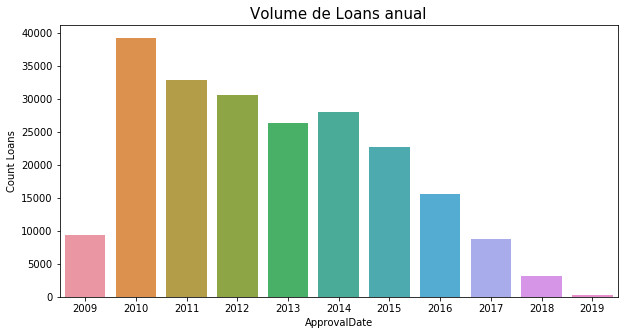

In [23]:
# http://www.jesshamrick.com/2016/04/13/reproducible-plots/
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=year_volume.index, y='Count Loans',data=year_volume, dodge=False)
ax.axes.set_title("Volume de Loans anual",fontsize=15)

In [24]:
dados['ApprovalDate'].min()

Timestamp('2009-10-01 00:00:00')

In [25]:
dados['ApprovalDate'].max()

Timestamp('2019-09-30 00:00:00')

In [40]:
dados.columns

Index(['BorrCity', 'BorrState', 'BorrZip', 'BankName', 'BankCity', 'BankState',
       'BankZip', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate',
       'ApprovalFiscalYear', 'FirstDisbursementDate', 'DeliveryMethod',
       'subpgmdesc', 'InitialInterestRate', 'TermInMonths', 'NaicsCode',
       'NaicsDescription', 'FranchiseCode', 'FranchiseName', 'ProjectCounty',
       'ProjectState', 'SBADistrictOffice', 'CongressionalDistrict',
       'BusinessType', 'RevolverStatus', 'JobsSupported', 'Id'],
      dtype='object')

In [103]:
dados['Id'] = 'id'+ dados['Id'].astype(str)

In [148]:
# split_fn = space_time_split_dataset(train_start_date="2009-10-01",
#                                     train_end_date="2016-01-01",
#                                     holdout_end_date="2019-09-30",
#                                     split_seed=42,
#                                     space_holdout_percentage=0.2,
#                                     space_column="Id",
#                                     time_column="ApprovalDate")

## Splitting the original data into train/test datasets
from fklearn.preprocessing.splitting import time_split_dataset
train_data, test_data = time_split_dataset(dados, 
                                           train_start_date="2009-10-01",
                                           train_end_date="2016-01-01",
                                           holdout_end_date="2019-08-30",
                                           time_column="ApprovalDate")

# dados_amostral = dados.sample(n = 10000)
# # train_set, out_of_space_ho, out_of_time_ho, out_of_space_time_ho =  split_fn(dados_amostral)
# train_set, out_of_space_ho, out_of_time_ho, out_of_space_time_ho =  split_fn(dados_amostral)

In [149]:
print(train_set.shape)
print(test_data.shape)

(8000, 28)
(0, 28)


In [130]:
print(train_set.shape)
print(out_of_space_ho.shape)
print(out_of_time_ho.shape)
print(out_of_space_time_ho.shape)

(8000, 28)
(2000, 28)
(0, 28)
(0, 28)


In [123]:
print(train_set.ApprovalDate.min())
print(train_set.ApprovalDate.max())

2009-10-01 00:00:00
2014-03-13 00:00:00


In [126]:
print(out_of_space_ho.ApprovalDate.min())
print(out_of_space_ho.ApprovalDate.max())

2009-10-02 00:00:00
2014-03-13 00:00:00


In [125]:
print(out_of_time_ho.ApprovalDate.min())
print(out_of_time_ho.ApprovalDate.max())

NaT
NaT


### 3.1 Imputação

Imputação de mediana nas variáveis numéricas (no caso serve apenas para ValorCompraAnual).

Imputação de `unk` (para unknown) para as variáveis categóricas (não se aplica para essa base).

In [28]:
numerical_variables = dados.describe().transpose().index.tolist()
categorical_variables = list(set(dados.columns.tolist()) - set(numerical_variables))
numerical_variables.remove('Target')
numerical_variables.remove('Id')
print('Variveis numericas: ',numerical_variables)
print('Variveis categoricas: ',categorical_variables)

Variveis numericas:  ['GrossApproval', 'SBAGuaranteedApproval', 'ApprovalFiscalYear', 'InitialInterestRate', 'TermInMonths', 'RevolverStatus', 'JobsSupported']
Variveis categoricas:  ['FranchiseName', 'ProjectState', 'FranchiseCode', 'ProjectCounty', 'CongressionalDistrict', 'BorrCity', 'NaicsCode', 'BankCity', 'BankZip', 'BusinessType', 'BorrState', 'ApprovalDate', 'BankName', 'BankState', 'subpgmdesc', 'DeliveryMethod', 'NaicsDescription', 'SBADistrictOffice', 'BorrZip', 'FirstDisbursementDate']


In [29]:
from fklearn.training.imputation import imputer, placeholder_imputer
from toolz import compose

num_impute_learner = imputer(columns_to_impute=numerical_variables,
                             impute_strategy="median")

cat_impute_learner = placeholder_imputer(columns_to_impute=categorical_variables,
                                          placeholder_value="unk")

#tupla que retorna: [0] a funcao, [1] dataset e [2] log
num_impute_fn, _, num_impute_log = num_impute_learner(train_set)
cat_impute_fn, _, cat_impute_log = cat_impute_learner(train_set)

compose(num_impute_fn, cat_impute_fn)(train_set).isnull().mean()

BorrCity                0.00
BorrState               0.00
BorrZip                 0.00
BankName                0.00
BankCity                0.00
BankState               0.00
BankZip                 0.00
GrossApproval           0.00
SBAGuaranteedApproval   0.00
ApprovalDate            0.00
ApprovalFiscalYear      0.00
FirstDisbursementDate   0.00
DeliveryMethod          0.00
subpgmdesc              0.00
InitialInterestRate     0.00
TermInMonths            0.00
NaicsCode               0.00
NaicsDescription        0.00
FranchiseCode           0.00
FranchiseName           0.00
ProjectCounty           0.00
ProjectState            0.00
SBADistrictOffice       0.00
CongressionalDistrict   0.00
BusinessType            0.00
RevolverStatus          0.00
JobsSupported           0.00
Target                  0.00
Id                      0.00
dtype: float64

### 3.2 Tratamento Outliers, Dummies e Label encoder
Aplica-se um **capper** para valores acima de um certo valor e o **foorer** para aplicar um threshold inferior. Não se aplica na base.

**One hot encoder** para variáveis categóricas com baixa cardinalidade.

**Label encoder** para variáveis categóricas com alta cardinalidade.

In [30]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dados.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GrossApproval,216989.00,313933.06,597664.30,1000.00,30000.00,100000.00,300000.00,5000000.00
SBAGuaranteedApproval,216989.00,233800.52,469588.56,500.00,17500.00,53000.00,204975.00,5250000.00
ApprovalFiscalYear,216989.00,2012.91,2.23,2010.00,2011.00,2013.00,2015.00,2019.00
InitialInterestRate,216989.00,6.32,1.43,0.00,5.50,6.00,7.05,12.50
TermInMonths,216989.00,104.08,73.26,0.00,60.00,84.00,120.00,360.00
RevolverStatus,216989.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
JobsSupported,216989.00,11.15,22.12,0.00,2.00,5.00,12.00,2150.00
Target,216989.00,0.08,0.28,0.00,0.00,0.00,0.00,1.00
Id,216989.00,108495.00,62639.47,1.00,54248.00,108495.00,162742.00,216989.00


In [31]:
from fklearn.training.transformation import capper, floorer
from fklearn.training.transformation import label_categorizer
from fklearn.training.transformation import onehot_categorizer

# Capping altos
capper_fn = capper(columns_to_cap=['GrossApproval', 'SBAGuaranteedApproval'], 
                   precomputed_caps={'GrossApproval': 5000000,
                                     'SBAGuaranteedApproval': 5250000
                                    })

# One hot encoding (cria dummies)
categorical_features_onehot = ['BusinessType', 'DeliveryMethod', 'subpgmdesc']
oh_encode_learner = onehot_categorizer(columns_to_categorize=categorical_features_onehot,
                                       hardcode_nans=False, # hardcodes an extra column with 1 if nan or unseen else 0
                                       drop_first_column=True)

# Label encoding
categorical_features_label_encoding = list(set(categorical_variables) - set(categorical_features_onehot) 
                                           - set(['ApprovalDate']))
le_encode_learner = label_categorizer(
                                columns_to_categorize=categorical_features_label_encoding,
                                store_mapping=True,
)

## 4. Pipeline

In [32]:
from fklearn.training.pipeline import build_pipeline

pipeline_learner = build_pipeline(
    capper_fn,
    num_impute_learner,
    cat_impute_learner,
    oh_encode_learner,
    le_encode_learner
)

In [33]:
## Using the created pipeline I transform my data
_, pre_processed_data, _ = pipeline_learner(dados)
#_, pre_processed_data, _ = pipeline_learner(dados_amostral)

In [34]:
train_set, out_of_space_ho, out_of_time_ho, out_of_space_time_ho =  split_fn(pre_processed_data)

In [35]:
train_set.columns.tolist()

['BorrCity',
 'BorrState',
 'BorrZip',
 'BankName',
 'BankCity',
 'BankState',
 'BankZip',
 'GrossApproval',
 'SBAGuaranteedApproval',
 'ApprovalDate',
 'ApprovalFiscalYear',
 'FirstDisbursementDate',
 'InitialInterestRate',
 'TermInMonths',
 'NaicsCode',
 'NaicsDescription',
 'FranchiseCode',
 'FranchiseName',
 'ProjectCounty',
 'ProjectState',
 'SBADistrictOffice',
 'CongressionalDistrict',
 'RevolverStatus',
 'JobsSupported',
 'Target',
 'Id',
 'fklearn_feat__BusinessType==CORPORATION',
 'fklearn_feat__BusinessType==INDIVIDUAL',
 'fklearn_feat__BusinessType==PARTNERSHIP',
 'fklearn_feat__BusinessType==unk',
 'fklearn_feat__DeliveryMethod==CA',
 'fklearn_feat__DeliveryMethod==CLP',
 'fklearn_feat__DeliveryMethod==COMM EXPRS',
 'fklearn_feat__DeliveryMethod==DFP',
 'fklearn_feat__DeliveryMethod==EWCP',
 'fklearn_feat__DeliveryMethod==EXIM',
 'fklearn_feat__DeliveryMethod==EXPRES EXP',
 'fklearn_feat__DeliveryMethod==GO LOANS',
 'fklearn_feat__DeliveryMethod==INTER TRDE',
 'fklearn_fea

## 5. Métodos de Seleção
Filtro, wrapper, embedded

In [36]:
# cols = ['Target', 'fklearn_feat__PerfilEconomico==3', 'fklearn_feat__Sexo==mulher', 'fklearn_feat__PerfilCompra==8','fklearn_feat__RegiaodoPais==Região Sul']
# train_df_copy = train_df
# test_df_copy = test_df
# for col in cols:
#     if col in train_df_copy.columns:
#         train_df_copy = train_df_copy.drop(columns=col, axis=1)
#     if col in test_df_copy.columns:
#         test_df_copy = test_df_copy.drop(columns=col, axis=1)

explicativas_train = train_set[list(set(train_set) - set(['ApprovalFiscalYear', 'ApprovalFiscalYear', 'ApprovalDate', 'FirstDisbursementDate', 'Target']))]
target_train = train_set['Target']

explicativas_test = out_of_time_ho[list(set(out_of_time_ho) - set(['ApprovalFiscalYear', 'ApprovalFiscalYear', 'ApprovalDate', 'FirstDisbursementDate', 'Target']))]
target_test = out_of_time_ho['Target']

### 5.1 Baseado em Filtro

In [37]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

x_norm = MinMaxScaler().fit_transform(explicativas_train)

# chamada do objeto
chi2_selector = SelectKBest(chi2)

chi2_selector.fit(x_norm, target_train)

chi_s = chi2_selector.get_support()

chi_feature = explicativas_train.loc[:,chi_s].columns.tolist()
print(str(len(chi_feature)), 'variaveis selecionadas')
print(chi_feature)

10 variaveis selecionadas
['fklearn_feat__subpgmdesc==Patriot Express', 'fklearn_feat__DeliveryMethod==SLA', 'TermInMonths', 'fklearn_feat__DeliveryMethod==PLP', 'fklearn_feat__subpgmdesc==Community Express', 'GrossApproval', 'fklearn_feat__DeliveryMethod==PATRIOT EX', 'fklearn_feat__DeliveryMethod==COMM EXPRS', 'fklearn_feat__subpgmdesc==Lender Advantage Initiative', 'fklearn_feat__subpgmdesc==Guaranty']


### 5.2 Wrapper

In [38]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# chamada do objeto
rfe_selector = RFE(estimator=LogisticRegression(), step=10) #default is half, n_features_to_select=10)

rfe_selector.fit(explicativas_train, target_train)
rfe_support = rfe_selector.get_support()
rfe_feature = explicativas_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'variaveis selecionadas:')
print(rfe_feature)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


29 variaveis selecionadas:
['ProjectState', 'fklearn_feat__subpgmdesc==Patriot Express', 'fklearn_feat__DeliveryMethod==SLA', 'TermInMonths', 'fklearn_feat__subpgmdesc==Standard Asset Based', 'fklearn_feat__DeliveryMethod==OTH 7A', 'fklearn_feat__DeliveryMethod==PLP', 'InitialInterestRate', 'NaicsCode', 'fklearn_feat__subpgmdesc==FA$TRK (Small Loan Express)', 'RevolverStatus', 'fklearn_feat__subpgmdesc==Revolving Line of Credit Exports - Sec. 7(a) (14)', 'BorrState', 'JobsSupported', 'fklearn_feat__BusinessType==INDIVIDUAL', 'fklearn_feat__DeliveryMethod==EWCP', 'fklearn_feat__DeliveryMethod==SBA EXPRES', 'fklearn_feat__subpgmdesc==Community Express', 'BankState', 'fklearn_feat__BusinessType==CORPORATION', 'fklearn_feat__DeliveryMethod==PATRIOT EX', 'fklearn_feat__DeliveryMethod==COMM EXPRS', 'fklearn_feat__DeliveryMethod==CA', 'fklearn_feat__subpgmdesc==Lender Advantage Initiative', 'fklearn_feat__subpgmdesc==Guaranty', 'fklearn_feat__BusinessType==PARTNERSHIP', 'NaicsDescription', 'S

### 5.3 Random Forest

In [39]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

em_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
em_selector.fit(explicativas_train, target_train)

em_sup = em_selector.get_support()
em_feature = explicativas_train.loc[:,em_sup].columns.tolist()
print(str(len(em_feature)), 'variaveis selecionadas:')
print(em_feature)

19 variaveis selecionadas:
['ProjectState', 'Id', 'TermInMonths', 'ProjectCounty', 'CongressionalDistrict', 'InitialInterestRate', 'BorrCity', 'NaicsCode', 'BankCity', 'BankZip', 'BorrState', 'JobsSupported', 'BankName', 'SBAGuaranteedApproval', 'BankState', 'GrossApproval', 'NaicsDescription', 'SBADistrictOffice', 'BorrZip']


### 5.4 Comparando Filtro, Wrapper e Random Forest

In [40]:
feature_selection_df = pd.DataFrame({'Variaveis':explicativas_train.columns,
                                     'chi2':chi_s,
                                     'RFE': rfe_support,
                                     'Random forest': em_sup})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total', 'Variaveis'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [41]:
feature_selection_df

,Variaveis,chi2,RFE,Random forest,Total
1,TermInMonths,True,True,True,3
2,fklearn_feat__subpgmdesc==Patriot Express,True,True,False,2
3,fklearn_feat__subpgmdesc==Lender Advantage Ini...,True,True,False,2
4,fklearn_feat__subpgmdesc==Guaranty,True,True,False,2
5,fklearn_feat__subpgmdesc==Community Express,True,True,False,2
6,fklearn_feat__DeliveryMethod==SLA,True,True,False,2
7,fklearn_feat__DeliveryMethod==PLP,True,True,False,2
8,fklearn_feat__DeliveryMethod==PATRIOT EX,True,True,False,2
9,fklearn_feat__DeliveryMethod==COMM EXPRS,True,True,False,2
10,SBADistrictOffice,False,True,True,2


Selecionando features que apareceram em pelo menos dois métodos de seleção de variáveis:

In [42]:
var_select = feature_selection_df[feature_selection_df['Total'] > 1]['Variaveis'].tolist()

In [43]:
x_treino = explicativas_train[var_select]
y_treino = target_train

x_teste = explicativas_test[var_select]
y_teste = target_test

## 6. Modelagem usando Gridsearch e Cross Validation Kfold: Regressao Logística, Random Forest e Gradient Boosting)

### 6.1.1 Regressão Logística

In [44]:
from sklearn.linear_model import LogisticRegression
RL = LogisticRegression(random_state=42)

Dicionário de hyperparâmetros para o **GridSearch** da Regressão Logística

In [45]:
# hyperparameters = {"C":np.logspace(-3,3,7), 
#                    "penalty":["l1","l2"]} # l1 lasso l2 ridge

hyperparameters = {'penalty' : ['l1','l2'], 
                   'class_weight' : ['balanced', None], 
                   'C' : [0.001, 0.01, 0.1, 1, 10]
                  }

In [46]:
%%time
grid_RL = GridSearchCV(RL, 
                  hyperparameters, 
                  cv=10,
                  verbose=0)
grid_RL.fit(x_treino, y_treino)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

CPU times: user 3min 11s, sys: 11 s, total: 3min 22s
Wall time: 3min 6s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [47]:
grid_RL.best_params_

{'C': 10, 'class_weight': None, 'penalty': 'l1'}

Passo os melhores parametros do Gridsearch como argumentos na LogisticRegression():

In [48]:
RL = LogisticRegression(**grid_RL.best_params_, random_state=42)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [49]:
%%time
acuracias_RL_treino = cross_val_score(estimator=RL,
                            X = x_treino,
                            y = y_treino,
                            cv=10)

acuracias_RL_teste = cross_val_score(estimator=RL,
                            X = x_teste,
                            y = y_teste,
                            cv=10)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

CPU times: user 14 s, sys: 792 ms, total: 14.8 s
Wall time: 13.4 s


In [50]:
print('REGRESSAO LOGISTICA - Acuracia de Treino:',round(acuracias_RL_treino.mean()*100,2))
print('REGRESSAO LOGISTICA - Acuracia de Teste:',round(acuracias_RL_teste.mean()*100,2))

REGRESSAO LOGISTICA - Acuracia de Treino: 91.97
REGRESSAO LOGISTICA - Acuracia de Teste: 89.94


***********************
Metrics Report:
***********************
Classification Report:
***********************
  True Positive      35
  True Negative   24955
 False Negative    2688
 False Positive     163
       Accuracy  0.8976
      Precision  0.1768
         Recall  0.0129
    Specificity  0.9935
       F1 Score  0.0240
  Roc Auc Score  0.7641
***********************
Confusion matrix, without normalization:


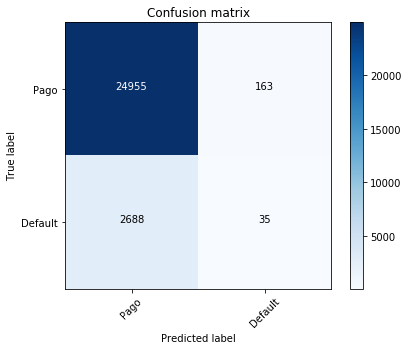

***********************
Roc Curve:
***********************


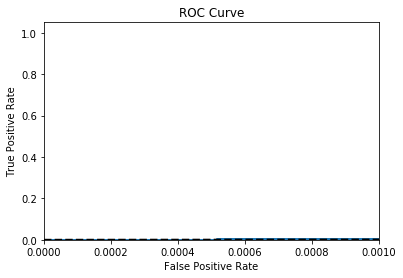

***********************
Precision Recall Curve:
***********************


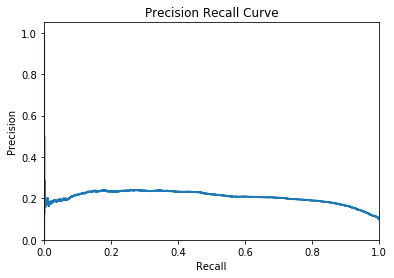

In [51]:
classes = ['Pago','Default']
y_pred = grid_RL.predict(x_teste)
y_scores_RL = grid_RL.predict_proba(x_teste)[:,1]

HelperClass.show_full_classification_report(y_teste, y_pred, y_scores_RL, classes)

### 6.1.2 K-nearest neighbors (KNN)

Dicionário de hyperparâmetros para o **GridSearch** do KNN

In [52]:
parametros_grid = {'n_neighbors': [3, 5, 7],
                   'weights': ['uniform', 'distance']
                  }

KNN = KNeighborsClassifier()

In [53]:
%%time
from sklearn.model_selection import GridSearchCV

grid_KNN = GridSearchCV(estimator=KNN,
                    param_grid=parametros_grid,
                    scoring='recall',
                    cv=10)
grid_KNN.fit(x_treino, y_treino)

CPU times: user 1min 23s, sys: 766 ms, total: 1min 24s
Wall time: 1min 26s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [54]:
grid_KNN.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [55]:
grid_KNN.best_score_

0.17305413165043232

Passo os melhores parâmetros do Gridsearch como argumentos na KNeighborsClassifier():

In [56]:
%%time
KNN = KNeighborsClassifier(**grid_KNN.best_params_)
KNN.fit(x_treino, y_treino)

CPU times: user 857 ms, sys: 20.9 ms, total: 878 ms
Wall time: 922 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [57]:
%%time
from sklearn.model_selection import cross_val_score
acuracias_KNN_treino = cross_val_score(estimator=KNN,
                            X = x_treino,
                            y = y_treino,
                            cv=10)

acuracias_KNN_teste = cross_val_score(estimator=KNN,
                            X = x_teste,
                            y = y_teste,
                            cv=10)

CPU times: user 12.6 s, sys: 159 ms, total: 12.8 s
Wall time: 12.9 s


In [58]:
print('RANDOM FOREST - Acuracia de Treino:',round(acuracias_KNN_treino.mean()*100,2))
print('RANDOM FOREST - Acuracia de Teste:',round(acuracias_KNN_teste.mean()*100,2))

RANDOM FOREST - Acuracia de Treino: 90.64
RANDOM FOREST - Acuracia de Teste: 89.6


***********************
Metrics Report:
***********************
Classification Report:
***********************
  True Positive     463
  True Negative   24246
 False Negative    2260
 False Positive     872
       Accuracy  0.8875
      Precision  0.3468
         Recall  0.1700
    Specificity  0.9653
       F1 Score  0.2282
  Roc Auc Score  0.6366
***********************
Confusion matrix, without normalization:


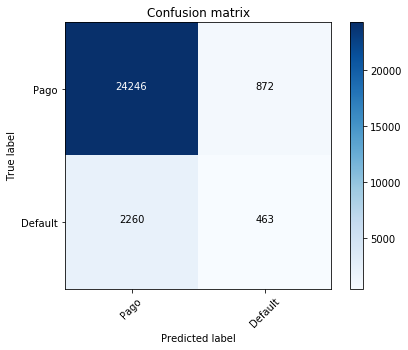

***********************
Roc Curve:
***********************


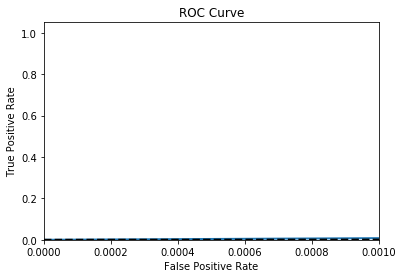

***********************
Precision Recall Curve:
***********************


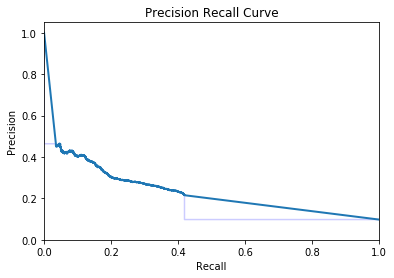

In [59]:
classes = ['Pago','Default']
y_pred = grid_KNN.predict(x_teste)
y_scores_KNN = grid_KNN.predict_proba(x_teste)[:,1]

HelperClass.show_full_classification_report(y_teste, y_pred, y_scores_KNN, classes)

### 6.1.3 Random Forest

Dicionário de hyperparâmetros para o **GridSearch** da Random Forest

In [60]:
%%time
from sklearn.ensemble import RandomForestClassifier

parametros_grid = {
    'n_estimators':[100],
    'criterion':['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': [2],
    'bootstrap':[True, False],
    'min_samples_leaf': [2,3],
    #'max_depth':[5]
}

RF = RandomForestClassifier(random_state=123)

CPU times: user 213 µs, sys: 784 µs, total: 997 µs
Wall time: 19.5 ms


In [61]:
%%time
from sklearn.model_selection import GridSearchCV

grid_RF = GridSearchCV(estimator=RF,
                    param_grid=parametros_grid,
                    scoring='accuracy',
                    cv=5)
grid_RF.fit(x_treino, y_treino)

CPU times: user 7min 24s, sys: 7.06 s, total: 7min 31s
Wall time: 8min


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [62]:
grid_RF.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 2,
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [63]:
grid_RF.best_score_

0.9411570335320318

Passo os melhores parâmetros do Gridsearch como argumentos na RandomForestClassifier():

In [64]:
%%time
RF = RandomForestClassifier(**grid_RF.best_params_, random_state=42)
RF.fit(x_treino, y_treino)

CPU times: user 15.8 s, sys: 178 ms, total: 16 s
Wall time: 16.2 s


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [65]:
%%time
from sklearn.model_selection import cross_val_score
acuracias_RF_treino = cross_val_score(estimator=RF,
                            X = x_treino,
                            y = y_treino,
                            cv=10)

acuracias_RF_teste = cross_val_score(estimator=RF,
                            X = x_teste,
                            y = y_teste,
                            cv=10)

CPU times: user 2min 38s, sys: 1.89 s, total: 2min 40s
Wall time: 2min 42s


In [66]:
print('RANDOM FOREST - Acuracia de Treino:',round(acuracias_RF_treino.mean()*100,2))
print('RANDOM FOREST - Acuracia de Teste:',round(acuracias_RF_teste.mean()*100,2))

RANDOM FOREST - Acuracia de Treino: 94.44
RANDOM FOREST - Acuracia de Teste: 94.99


***********************
Metrics Report:
***********************
Classification Report:
***********************
  True Positive    1031
  True Negative   24906
 False Negative    1692
 False Positive     212
       Accuracy  0.9316
      Precision  0.8294
         Recall  0.3786
    Specificity  0.9916
       F1 Score  0.5199
  Roc Auc Score  0.9365
***********************
Confusion matrix, without normalization:


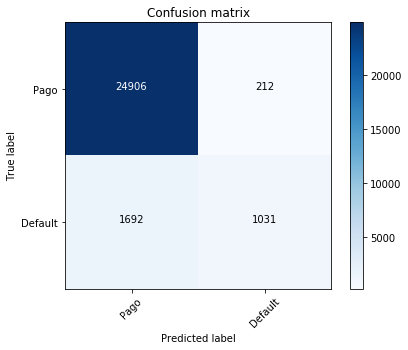

***********************
Roc Curve:
***********************


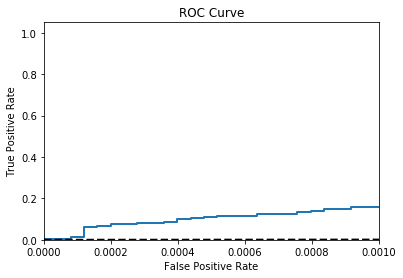

***********************
Precision Recall Curve:
***********************


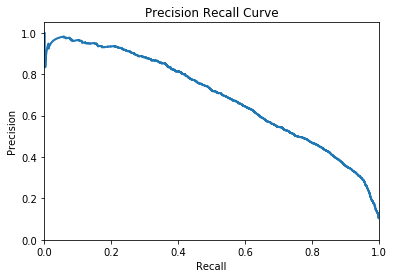

In [67]:
classes = ['Pago','Default']
y_pred = grid_RF.predict(x_teste)
y_scores_RF = grid_RF.predict_proba(x_teste)[:,1]

HelperClass.show_full_classification_report(y_teste, y_pred, y_scores_RF, classes)

### 6.1.4 Soft Voting Classifier: Combina 3 classificadores em 1

In [68]:
%%time
classes = ['Pago','Default']
voting_clf = VotingClassifier (
        estimators = [('lg', grid_RL), ('knn', grid_KNN), ('rf', grid_RF)], voting='soft')
    
voting_clf.fit(x_treino, y_treino)

y_pred = voting_clf.predict(x_teste)
y_scores_VotingClassifier = voting_clf.predict_proba(x_teste)[:,1]

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

CPU times: user 11min 42s, sys: 15.4 s, total: 11min 57s
Wall time: 11min 41s


***********************
Metrics Report:
***********************
Classification Report:
***********************
  True Positive     271
  True Negative   25019
 False Negative    2452
 False Positive      99
       Accuracy  0.9084
      Precision  0.7324
         Recall  0.0995
    Specificity  0.9961
       F1 Score  0.1752
  Roc Auc Score  0.8774
***********************
Confusion matrix, without normalization:


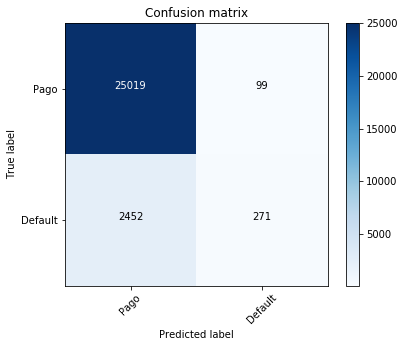

***********************
Roc Curve:
***********************


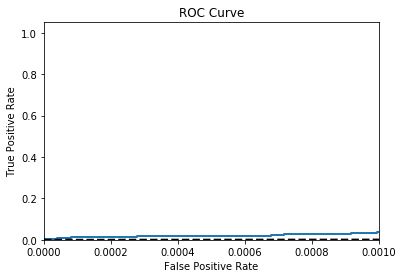

***********************
Precision Recall Curve:
***********************


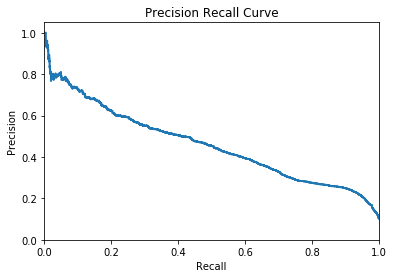

In [69]:
HelperClass.show_full_classification_report(y_teste, y_pred, y_scores_VotingClassifier, classes)

### 6.1.5 Gradient Boosting

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state=42)

Dicionário de hyperparâmetros para o **GridSearch** do Gradient Boosting

In [111]:
parametros_gb = {'min_samples_split': [3, 5],
                 'min_samples_leaf': [3, 5],
                 'max_depth': [3,5],
                 #'n_estimators':[2,5,20],
                 'n_estimators':[1000],
                 'loss':['deviance'],
                 'learning_rate': [0.05],# 0.2],
                 #'max_features':["log2","sqrt"],
                 #'criterion': ["friedman_mse",  "mae"],
                 #'subsample':[0.5,0.8, 1.0]
                }

In [112]:
%%time
from sklearn.model_selection import GridSearchCV

# assinatura do objeto
grid_GB = GridSearchCV(estimator=GB,
                       param_grid=parametros_gb,
                       cv=5,
                       n_jobs=-1) # tenta rodar em paralelo, se possível
grid_GB.fit(x_treino, y_treino)

CPU times: user 4min 7s, sys: 5.37 s, total: 4min 13s
Wall time: 1h 42min 54s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='deviance', max_depth=5,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=5,
                                                  min_samples_split=3,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...
                                                  presort='auto',
  

In [108]:
grid_GB.best_score_

0.9503694206902021

In [109]:
grid_GB.best_params_

{'learning_rate': 0.05,
 'loss': 'deviance',
 'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 100}

Passo os melhores parâmetros do Gridsearch como argumentos na GradientBoostingClassifier():

In [113]:
%%time
GB = GradientBoostingClassifier(**grid_GB.best_params_, random_state=42)
GB.fit(x_treino, y_treino)

KeyboardInterrupt: 

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [114]:
%%time
from sklearn.model_selection import cross_val_score
acuracias_GB_treino = cross_val_score(estimator=GB,
                            X = x_treino,
                            y = y_treino,
                            cv=5)

acuracias_GB_teste = cross_val_score(estimator=GB,
                            X = x_teste,
                            y = y_teste,
                            cv=5)

KeyboardInterrupt: 

In [115]:
print('GRADIENT BOOSTING - Acuracia de Treino:',round(acuracias_GB_treino.mean()*100,2))
print('GRADIENT BOOSTING - Acuracia de Teste:',round(acuracias_GB_teste.mean()*100,2))

GRADIENT BOOSTING - Acuracia de Treino: 95.04
GRADIENT BOOSTING - Acuracia de Teste: 96.77


***********************
Metrics Report:
***********************
Classification Report:
***********************
  True Positive    1734
  True Negative   24720
 False Negative     989
 False Positive     398
       Accuracy  0.9502
      Precision  0.8133
         Recall  0.6368
    Specificity  0.9842
       F1 Score  0.7143
  Roc Auc Score  0.9750
***********************
Confusion matrix, without normalization:


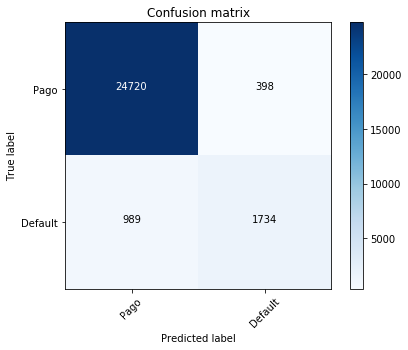

***********************
Roc Curve:
***********************


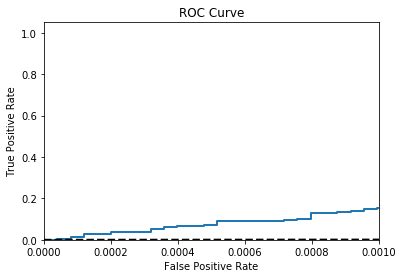

***********************
Precision Recall Curve:
***********************


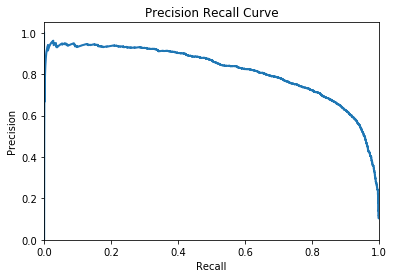

In [116]:
classes = ['Pago','Default']
y_pred = grid_GB.predict(x_teste)
y_scores_GB = grid_GB.predict_proba(x_teste)[:,1]

HelperClass.show_full_classification_report(y_teste, y_pred, y_scores_GB, classes)

### 6.1.6 XGBoosting

In [ ]:
# %%time
# from sklearn.metrics import roc_auc_score, log_loss
# # An experiment to understand why weak learners work better:
# max_depth = np.unique(np.random.randint(3, 15, size=7))
# num_estimators = np.unique(np.concatenate((np.random.randint(3, 15, size=7), np.random.randint(15, 100, size=5)),axis=0))

# auc = pd.DataFrame()

# for depth in max_depth:
#     for tot_trees in num_estimators:
        
#         xgb_ = XGBClassifier(max_depth=depth, num_estimators=tot_trees)
#         xgb_.fit(x_treino, y_treino)
        
#         test_xgb  = xgb_.predict_proba(x_teste)[:,1]
#         auc_test  = roc_auc_score(y_teste.values, test_xgb)
        

#         auc = pd.concat([auc, pd.DataFrame(data={'AUC': [auc_test], 'max_depth':[depth] , 'num_estimators':[tot_trees]})], axis=0)
#         print(auc)

In [99]:
from xgboost import XGBClassifier

XGB = XGBClassifier(random_state=42)

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters_xgb = {#'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':['binary:logistic'],
                  'learning_rate': [0.05,0.1], #so called `eta` value
                  'max_depth': [2],
                  'min_child_weight': [11],
                  #'silent': [1],
                  #'subsample': [0.8],
                  #'colsample_bytree': [0.7],
                  'n_estimators': [1000], #number of trees, change it to 1000 for better results
                  'scale_pos_weight':[3]
                  #'missing':[-999],
                  #'seed': [1337],
                  #'lambda':[1.2, 1.3],
                  #'alpha':[1.2, 1.3],

                 }

In [100]:
%%time
from sklearn.model_selection import GridSearchCV

# assinatura do objeto
grid_XGB = GridSearchCV(estimator=XGB,
                       param_grid=parameters_xgb,
                       cv=5,
                       n_jobs=-1) # tenta rodar em paralelo, se possível
grid_XGB.fit(x_treino, y_treino)

CPU times: user 1min 58s, sys: 477 ms, total: 1min 59s
Wall time: 9min 16s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2],
                         'min_child_weight': [11], 'n_estimators': [1000],
                    

In [101]:
grid_XGB.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 11,
 'n_estimators': 1000,
 'objective': 'binary:logistic',
 'scale_pos_weight': 3}

Passo os melhores parâmetros do Gridsearch como argumentos na XGBClassifier():

In [102]:
%%time
XGB = XGBClassifier(**grid_XGB.best_params_, random_state=42)
XGB.fit(x_treino, y_treino)

CPU times: user 2min, sys: 563 ms, total: 2min
Wall time: 2min 3s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
              silent=None, subsample=1, verbosity=1)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [103]:
%%time
from sklearn.model_selection import cross_val_score
acuracias_XGB_treino = cross_val_score(estimator=XGB,
                            X = x_treino,
                            y = y_treino,
                            cv=5)

acuracias_XGB_teste = cross_val_score(estimator=XGB,
                            X = x_teste,
                            y = y_teste,
                            cv=5)

CPU times: user 9min 21s, sys: 2.02 s, total: 9min 23s
Wall time: 9min 32s


In [104]:
print('GRADIENT BOOSTING - Acuracia de Treino:',round(acuracias_XGB_treino.mean()*100,2))
print('GRADIENT BOOSTING - Acuracia de Teste:',round(acuracias_XGB_teste.mean()*100,2))

GRADIENT BOOSTING - Acuracia de Treino: 94.69
GRADIENT BOOSTING - Acuracia de Teste: 96.52


***********************
Metrics Report:
***********************
Classification Report:
***********************
  True Positive    2132
  True Negative   24123
 False Negative     591
 False Positive     995
       Accuracy  0.9430
      Precision  0.6818
         Recall  0.7830
    Specificity  0.9604
       F1 Score  0.7289
  Roc Auc Score  0.9704
***********************
Confusion matrix, without normalization:


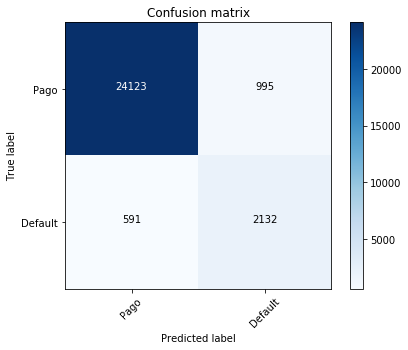

***********************
Roc Curve:
***********************


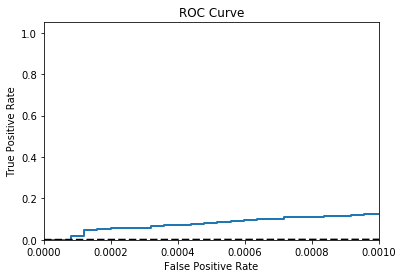

***********************
Precision Recall Curve:
***********************


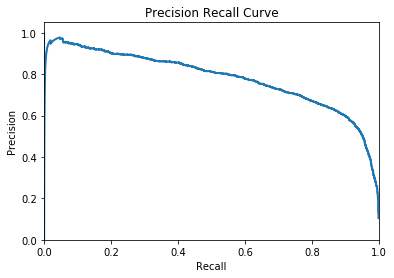

In [105]:
classes = ['Pago','Default']
y_pred = grid_XGB.predict(x_teste)
y_scores_XGB = grid_XGB.predict_proba(x_teste)[:,1]

HelperClass.show_full_classification_report(y_teste, y_pred, y_scores_XGB, classes)

### 6.1.4 Comparando Modelos

In [ ]:
modelos = pd.DataFrame({'Modelo': ['Regressao Logistica',
                                   'Random Forest',
                                   'Gradient Boosting',
                                   'XGboosting'
                                  ],
                        'Acuracia_treino':[round(acuracias_RL_treino.mean()*100,2), 
                                           round(acuracias_RF_treino.mean()*100,2),
                                           round(acuracias_GB_treino.mean()*100,2),
                                           round(acuracias_XGB_treino.mean()*100,2)],
                        'Acuracia_teste':[round(acuracias_RL_teste.mean()*100,2), 
                                          round(acuracias_RF_teste.mean()*100,2),
                                          round(acuracias_GB_teste.mean()*100,2),
                                          round(acuracias_XGB_teste.mean()*100,2)]
                       })

comparacao = modelos.sort_values(by='Acuracia_teste', ascending=False)
comparacao = comparacao[['Modelo', 'Acuracia_treino', 'Acuracia_teste']]

In [ ]:
comparacao

## 7. Salvando Modelo

Melhores estimadores do melhor modelo (com maior acurácia foi o Gradient Boosting):

In [ ]:
grid_GB.best_estimator_

In [ ]:
from sklearn.externals import joblib

# salva modelo Gradient Boosting
joblib.dump(grid_GB.best_estimator_, 'modelo_loan_gb_total.pkl', compress = 1)

In [ ]:
# salva modelo Random Forest
joblib.dump(grid_RF.best_estimator_, 'modelo_loan_rf_total.pkl', compress = 1)

In [ ]:
# salva modelo Regressao Logistica
joblib.dump(grid_RL.best_estimator_, 'modelo_loan_rl_total.pkl', compress = 1)

## 8. Recuperando Modelo Salvo

In [ ]:
modelo_treinado = open('modelo_loan_gb.pkl', 'rb')
model = joblib.load(modelo_treinado)

In [ ]:
model.predict(x_teste)

In [ ]:
model.predict_proba(x_teste)[:,1]